#### Benchmaking Experiment 004
- Model : Model4
- Dataset : PAMAP2
- Semantic Space : Glove50
- Cross Validation : 5-fold fixed classes
- Feature Loss : MSELoss

In [2]:
import os 
from datetime import date
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import pandas as pd

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

from src.datasets.data import PAMAP2Reader
from src.datasets.dataset import PAMAP2Dataset
from src.datasets.utils import load_attribute

from src.models.ts_transformer import TSTransformerEncoderClassiregressor, RelativeGlobalAttention
from src.models.loss import FeatureLoss, AttributeLoss 

from src.utils.analysis import action_evaluator
from src.running import train_step, eval_step

In [3]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2",
    "Model": "RelativeGlobalAttention",
    "sem-space": "glove50-v1",
    # model training configs
    "include_attribute_loss": True, 
    "semantic_size": 64,
    "n_actions": 18,
    "folding": True,
    "fold_classes": [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']],
    "lr": 0.001,
    "n_epochs": 10,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 200,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

---
Model Building

In [4]:
class Model6(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, ft_size, max_len=1024, dropout=0.1):
        super(Model6, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 

        # feature prep layer
        self.DenseL = nn.Linear(in_ft, d_model)
        # relative global attention layer
        self.AttnL = RelativeGlobalAttention(self.d_model, self.num_heads, self.max_len)
        # positional encoding concat <-> 1DConv 
        self.Act = F.relu#_get_activation_fn(activation)
        self.AvgPoolL = nn.AvgPool2d((self.max_len,1))
        self.DenseL2 = nn.Linear(self.d_model, self.ft_size)
        self.dropout = nn.Dropout1d(dropout)

    def forward(self, x):
        out = self.DenseL(x)
        out = self.AttnL(out)
        out = self.Act(out)
        out = self.AvgPoolL(out)
        out = torch.squeeze(out)
        out = self.dropout(out)
        out = self.DenseL2(out)        
        return out

---

In [5]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# import PAMAP2 dataset
dataReader = PAMAP2Reader('./data/PAMAP2_Dataset/Protocol/')
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\HAR-ZSL-XAI\src\datasets\data.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [7]:
# import PAMAP2 attributes
activity_dict, attribute_dict, attr_mat = load_attribute('./data/PAMAP2_Dataset/PAMAP2_attributes.json')
_, attr_size = attr_mat.shape

In [8]:
# Load semantic feature space 
st = config['sem-space']
if st == 'glove50-v1':
    fpath = './data/PAMAP2_Dataset/glove_features.npy'
elif st == 'glove50-v2':
    fpath = './data/PAMAP2_Dataset/glove_featureV2.npy'
elif st == 'video-V1':
    fpath = './data/PAMAP2_Dataset/video_pca_ft.npy'
elif st == 'word2vec-v1':
    fpath = './data/PAMAP2_Dataset/word2vec_features.npy'
elif st == 'word2vec-v2':
    fpath = './data/PAMAP2_Dataset/word2vec_featureV2.npy'

feat_mat = np.load(fpath)
n_actions, feat_size = feat_mat.shape

In [9]:
# run 5-fold running
fold_classes = config['fold_classes']
fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']


eval: 100%|██████████| 131/131 [00:01<00:00, 80.40batch/s, loss=0.141]


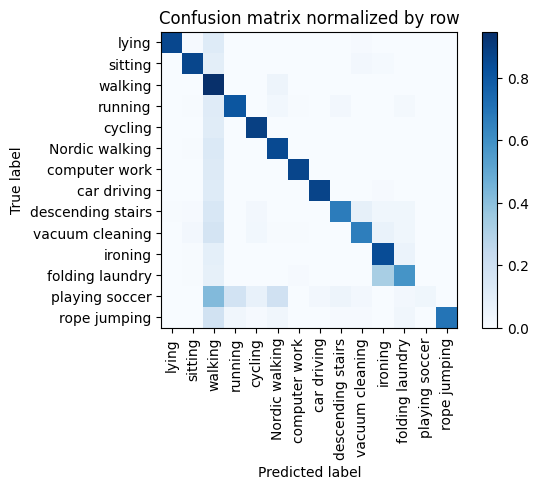

Training Epoch:  10%|█         | 1/10 [00:12<01:49, 12.13s/it]

Overall accuracy: 0.809



eval: 100%|██████████| 131/131 [00:01<00:00, 83.41batch/s, loss=0.0896]


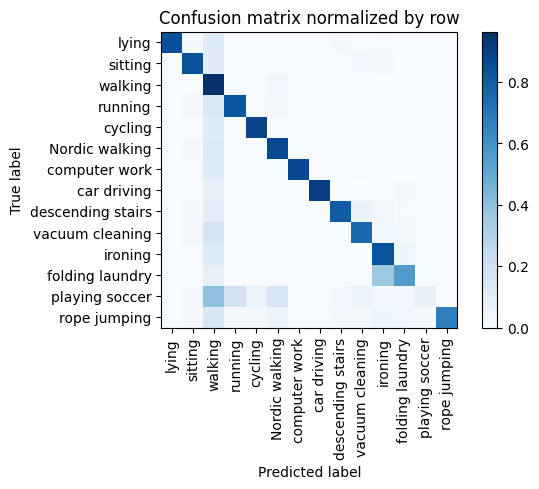

Training Epoch:  20%|██        | 2/10 [00:24<01:38, 12.29s/it]

Overall accuracy: 0.823



eval: 100%|██████████| 131/131 [00:01<00:00, 74.16batch/s, loss=0.104]


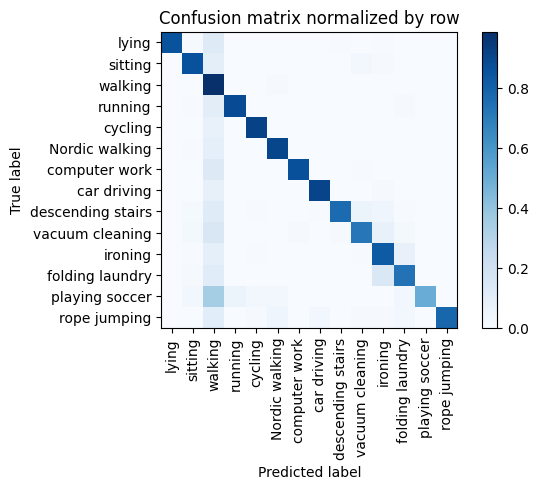

Training Epoch:  30%|███       | 3/10 [00:38<01:31, 13.12s/it]

Overall accuracy: 0.849



eval: 100%|██████████| 131/131 [00:01<00:00, 67.60batch/s, loss=0.0446]


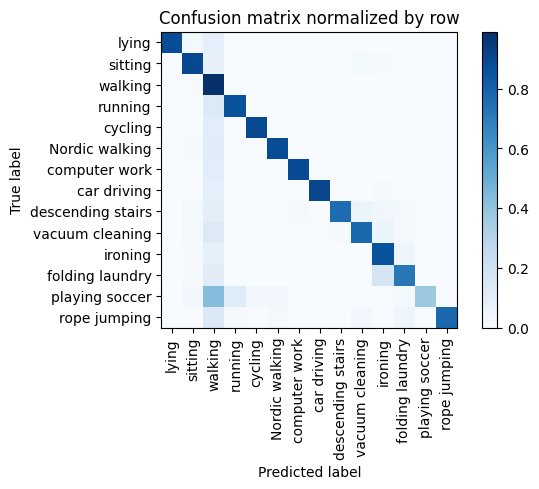

Training Epoch:  40%|████      | 4/10 [00:52<01:21, 13.60s/it]

Overall accuracy: 0.855



eval: 100%|██████████| 131/131 [00:01<00:00, 69.46batch/s, loss=0.0886]


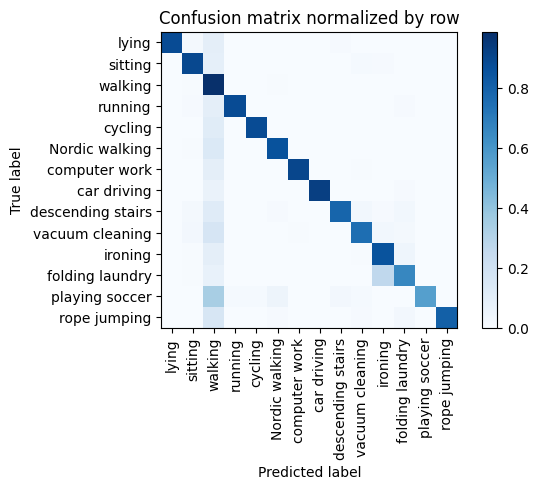

Training Epoch:  50%|█████     | 5/10 [01:06<01:08, 13.71s/it]

Overall accuracy: 0.857



eval: 100%|██████████| 131/131 [00:02<00:00, 64.70batch/s, loss=0.0682]


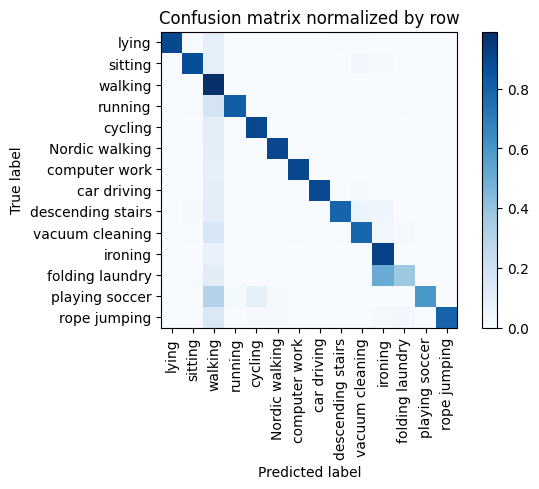

Training Epoch:  60%|██████    | 6/10 [01:22<00:57, 14.27s/it]

Overall accuracy: 0.857



eval: 100%|██████████| 131/131 [00:01<00:00, 66.57batch/s, loss=0.0481]


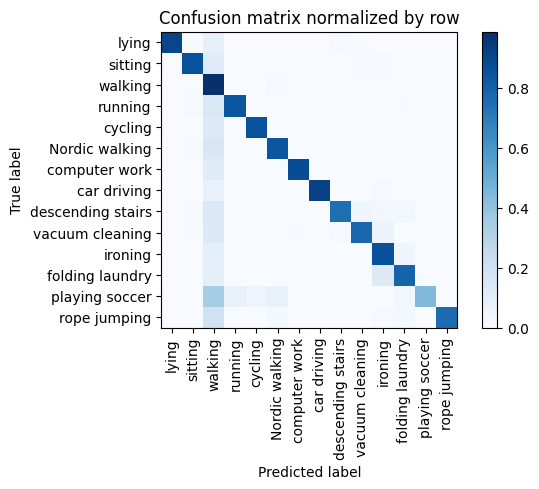

Training Epoch:  70%|███████   | 7/10 [01:37<00:43, 14.63s/it]

Overall accuracy: 0.853



eval: 100%|██████████| 131/131 [00:01<00:00, 69.57batch/s, loss=0.0528]


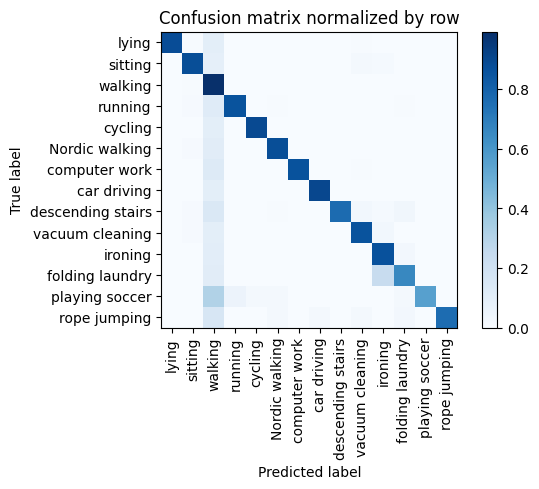

Training Epoch:  80%|████████  | 8/10 [01:51<00:28, 14.34s/it]

Overall accuracy: 0.862



eval: 100%|██████████| 131/131 [00:02<00:00, 62.56batch/s, loss=0.0641]


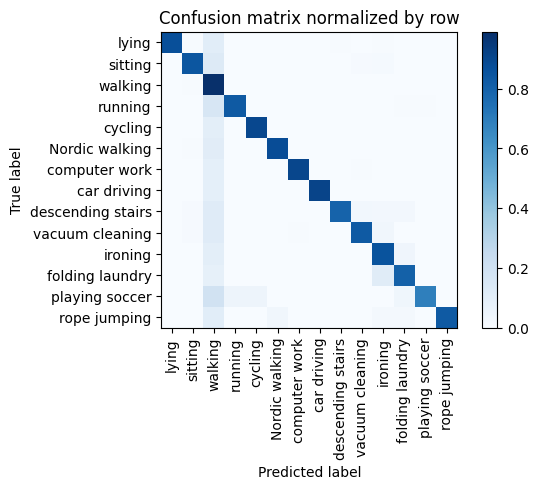

Training Epoch:  90%|█████████ | 9/10 [02:06<00:14, 14.49s/it]

Overall accuracy: 0.872



eval: 100%|██████████| 131/131 [00:02<00:00, 51.53batch/s, loss=0.0416]


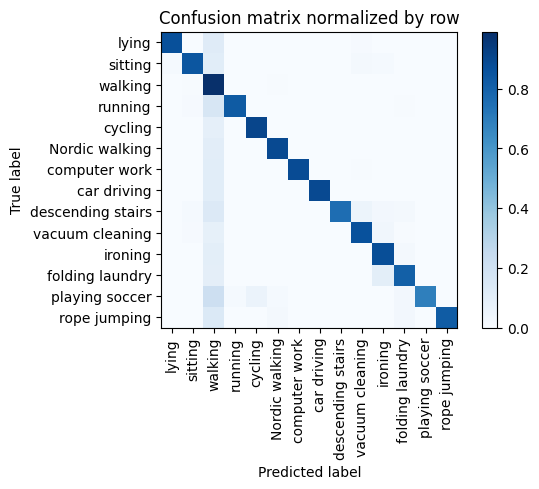

Overall accuracy: 0.873



eval: 100%|██████████| 141/141 [00:01<00:00, 92.20batch/s, loss=0.262]


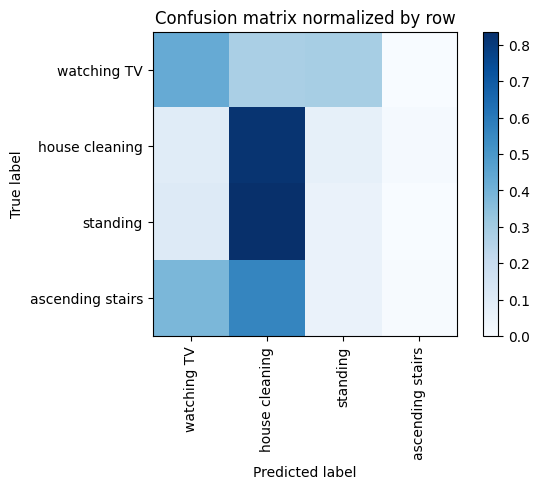

Overall accuracy: 0.352

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.189      0.055      0.085      0.330       1479|	 house cleaning: 0.835,	watching TV: 0.110,	
  house cleaning       0.387      0.819      0.526      0.328       1471|	 watching TV: 0.097,	standing: 0.071,	
ascending stairs       0.182      0.005      0.009      0.191        858|	 house cleaning: 0.558,	watching TV: 0.383,	standing: 0.054,	
     watching TV       0.314      0.429      0.363      0.151        679|	 standing: 0.290,	house cleaning: 0.281,	

----------------------------------------------------------------------------------------------------
     avg / total       0.272      0.352      0.257        1.0       4487|	      

{'total_accuracy': 0.3523512369066191, 'precision': 0.2680860093286392, 'recall': 0.32679269993408244, 'f1': 0.24567484983003354}
================ Fold-1 ================
Unseen Classes : ['walking', 'rope jumping',

eval: 100%|██████████| 132/132 [00:01<00:00, 69.33batch/s, loss=0.0494]


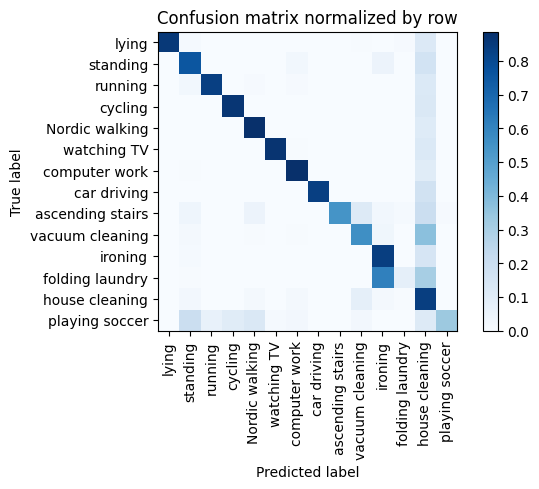

Training Epoch:  10%|█         | 1/10 [00:14<02:09, 14.38s/it]

Overall accuracy: 0.761



eval: 100%|██████████| 132/132 [00:01<00:00, 69.53batch/s, loss=0.105]


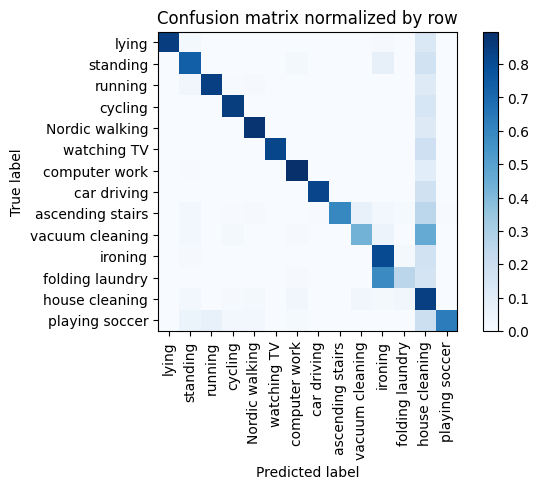

Training Epoch:  20%|██        | 2/10 [00:27<01:51, 13.93s/it]

Overall accuracy: 0.760



eval: 100%|██████████| 132/132 [00:01<00:00, 69.58batch/s, loss=0.0717]


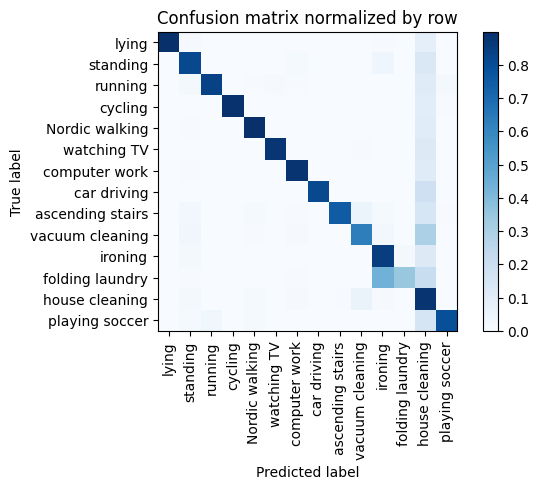

Training Epoch:  30%|███       | 3/10 [00:41<01:36, 13.81s/it]

Overall accuracy: 0.815



eval: 100%|██████████| 132/132 [00:01<00:00, 70.47batch/s, loss=0.0282]


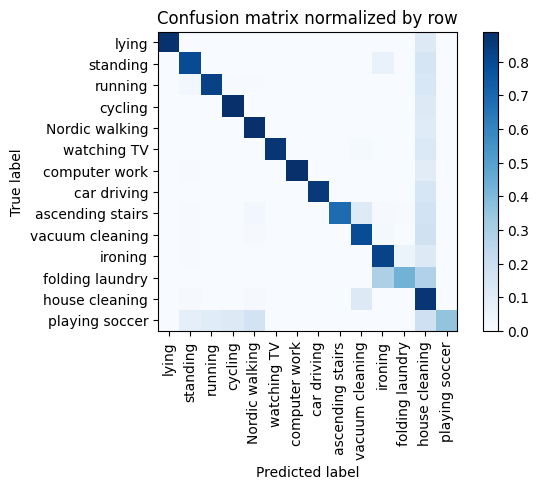

Training Epoch:  40%|████      | 4/10 [00:55<01:22, 13.76s/it]

Overall accuracy: 0.813



eval: 100%|██████████| 132/132 [00:01<00:00, 69.28batch/s, loss=0.135]


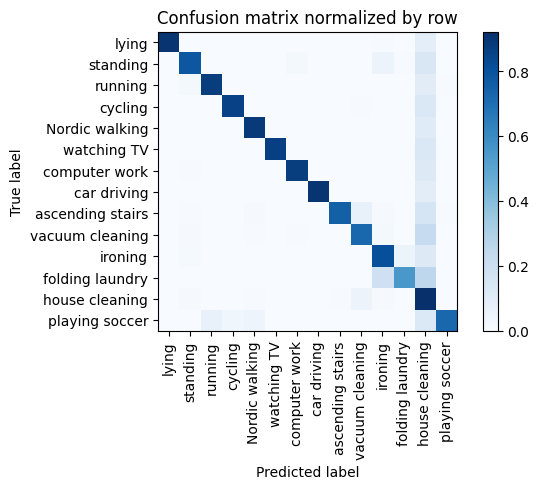

Training Epoch:  50%|█████     | 5/10 [01:09<01:10, 14.01s/it]

Overall accuracy: 0.830



eval: 100%|██████████| 132/132 [00:01<00:00, 69.28batch/s, loss=0.0345]


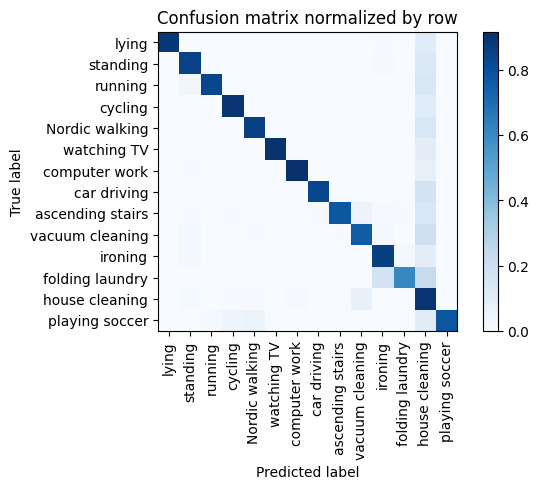

Training Epoch:  60%|██████    | 6/10 [01:23<00:55, 13.88s/it]

Overall accuracy: 0.851



eval: 100%|██████████| 132/132 [00:01<00:00, 68.44batch/s, loss=0.0826]


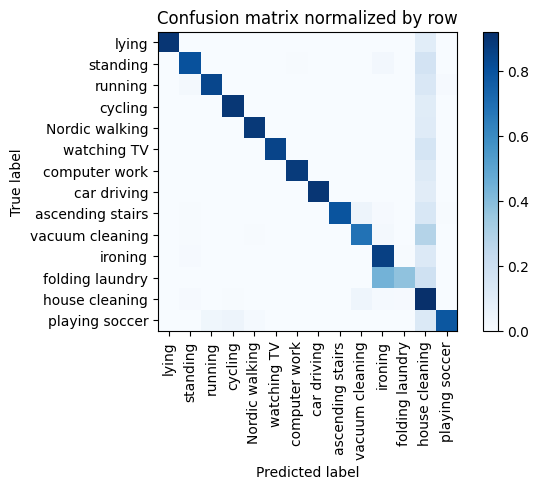

Training Epoch:  70%|███████   | 7/10 [01:36<00:41, 13.71s/it]

Overall accuracy: 0.827



eval: 100%|██████████| 132/132 [00:01<00:00, 68.23batch/s, loss=0.143]


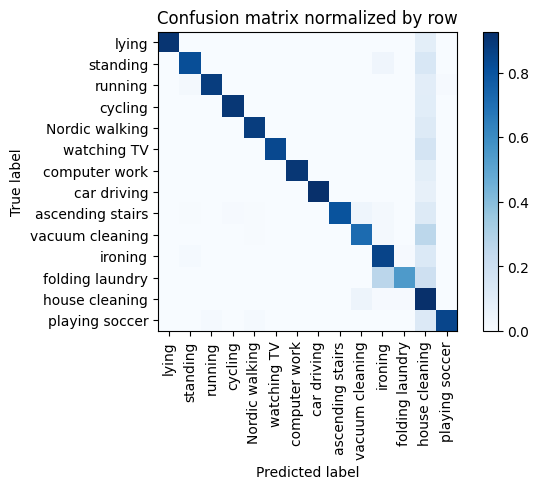

Training Epoch:  80%|████████  | 8/10 [01:50<00:27, 13.84s/it]

Overall accuracy: 0.848



eval: 100%|██████████| 132/132 [00:01<00:00, 67.38batch/s, loss=0.0201]


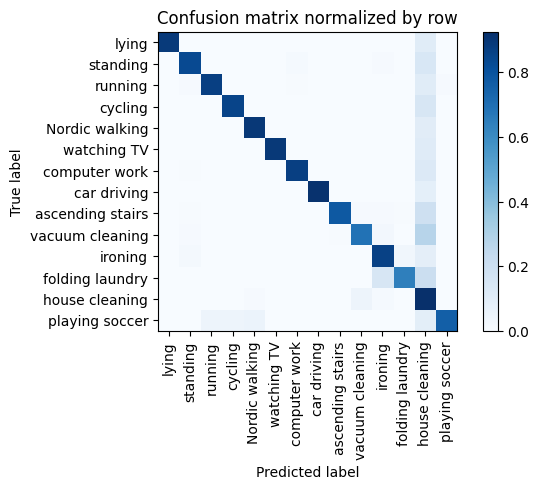

Training Epoch:  90%|█████████ | 9/10 [02:04<00:13, 13.72s/it]

Overall accuracy: 0.842



eval: 100%|██████████| 132/132 [00:02<00:00, 62.86batch/s, loss=0.112]


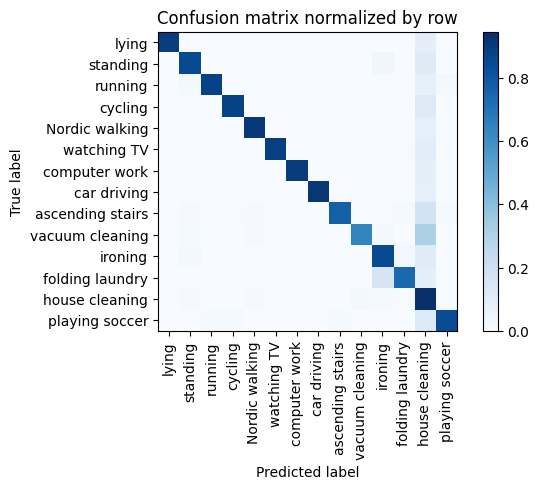

Overall accuracy: 0.855



eval: 100%|██████████| 140/140 [00:01<00:00, 99.29batch/s, loss=0.326] 


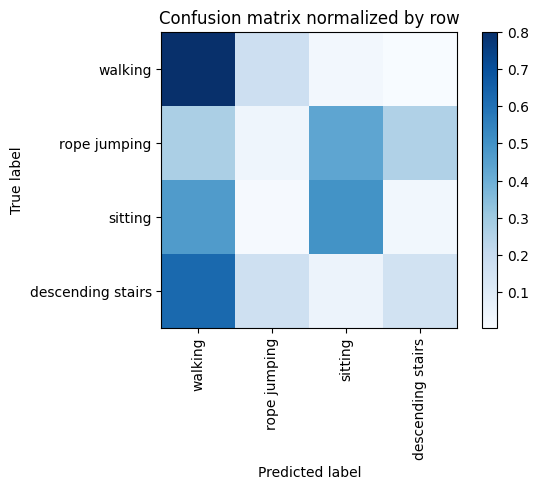

Overall accuracy: 0.526

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.544      0.800      0.648      0.418       1862|	 rope jumping: 0.172,	sitting: 0.023,	
          sitting       0.743      0.496      0.595      0.324       1444|	 walking: 0.465,	descending stairs: 0.028,	
descending stairs       0.450      0.159      0.235      0.170        759|	 walking: 0.623,	rope jumping: 0.167,	
     rope jumping       0.033      0.041      0.037      0.087        388|	 sitting: 0.430,	walking: 0.271,	descending stairs: 0.258,	

----------------------------------------------------------------------------------------------------
      avg / total       0.548      0.526      0.507        1.0       4453|	      

{'total_accuracy': 0.5261621378845722, 'precision': 0.44245272683042336, 'recall': 0.3741792753436521, 'f1': 0.37865054176472246}
================ Fold-2 ================
Unseen Classes : ['playing soccer', 'lying',

eval: 100%|██████████| 122/122 [00:01<00:00, 70.17batch/s, loss=0.0862]


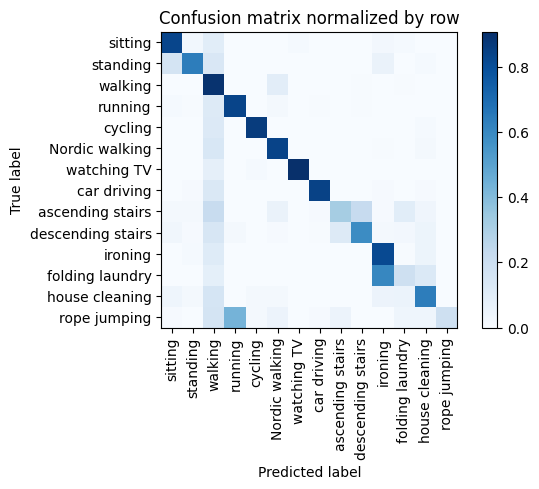

Training Epoch:  10%|█         | 1/10 [00:13<01:57, 13.10s/it]

Overall accuracy: 0.713



eval: 100%|██████████| 122/122 [00:01<00:00, 67.68batch/s, loss=0.0697]


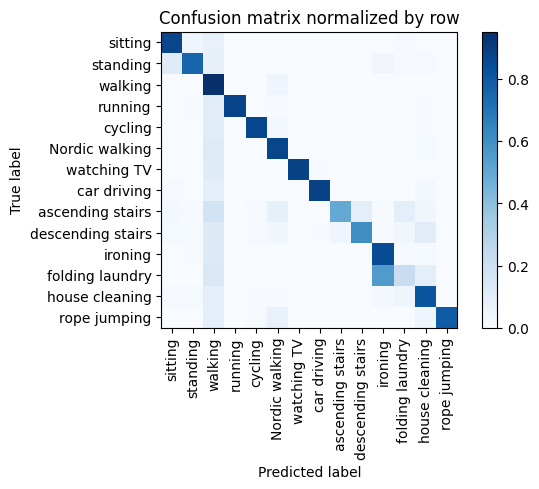

Training Epoch:  20%|██        | 2/10 [00:25<01:42, 12.85s/it]

Overall accuracy: 0.789



eval: 100%|██████████| 122/122 [00:01<00:00, 64.08batch/s, loss=0.0659]


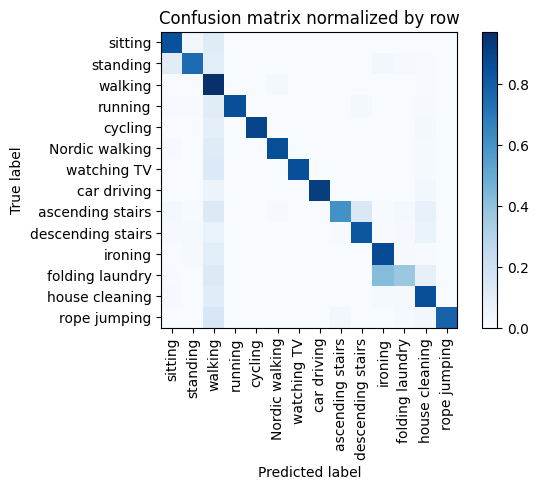

Training Epoch:  30%|███       | 3/10 [00:38<01:30, 12.89s/it]

Overall accuracy: 0.820



eval: 100%|██████████| 122/122 [00:01<00:00, 68.21batch/s, loss=0.0492]


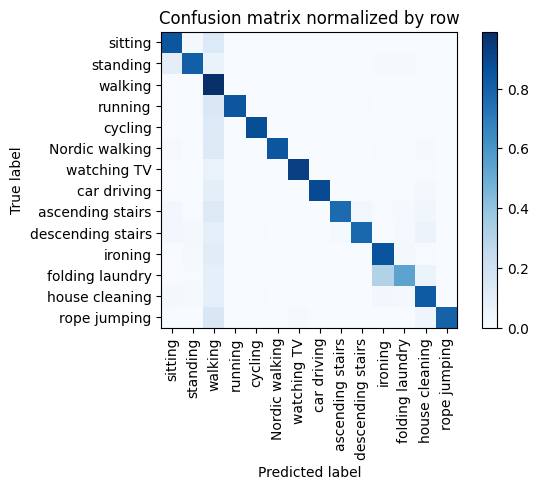

Training Epoch:  40%|████      | 4/10 [00:52<01:18, 13.15s/it]

Overall accuracy: 0.839



eval: 100%|██████████| 122/122 [00:01<00:00, 67.79batch/s, loss=0.0843]


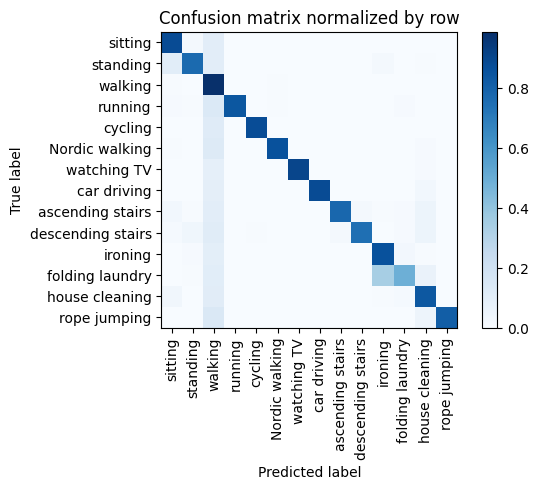

Training Epoch:  50%|█████     | 5/10 [01:05<01:05, 13.01s/it]

Overall accuracy: 0.835



eval: 100%|██████████| 122/122 [00:01<00:00, 67.53batch/s, loss=0.111]


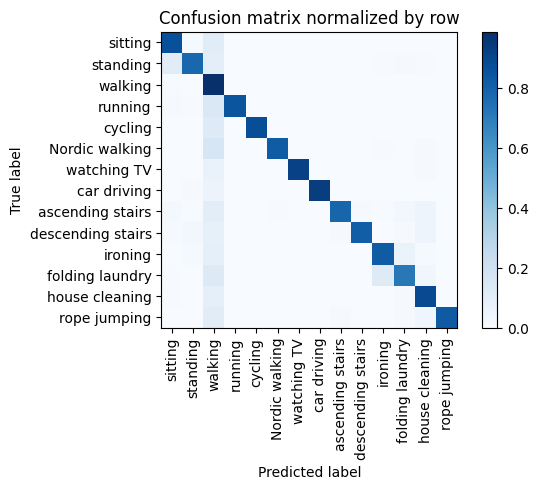

Training Epoch:  60%|██████    | 6/10 [01:17<00:51, 12.96s/it]

Overall accuracy: 0.851



eval: 100%|██████████| 122/122 [00:02<00:00, 48.82batch/s, loss=0.1]


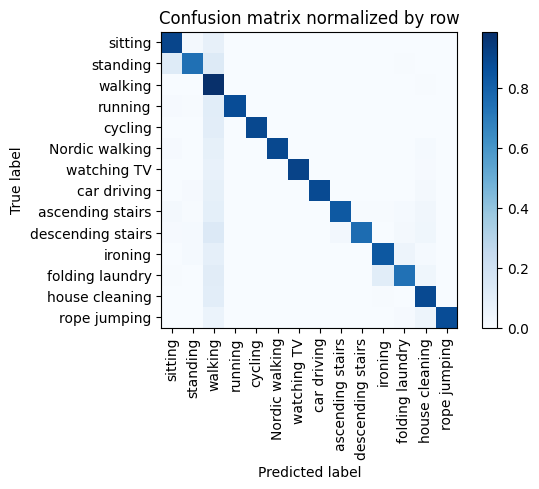

Training Epoch:  70%|███████   | 7/10 [01:31<00:39, 13.07s/it]

Overall accuracy: 0.864



eval: 100%|██████████| 122/122 [00:02<00:00, 60.82batch/s, loss=0.0697]


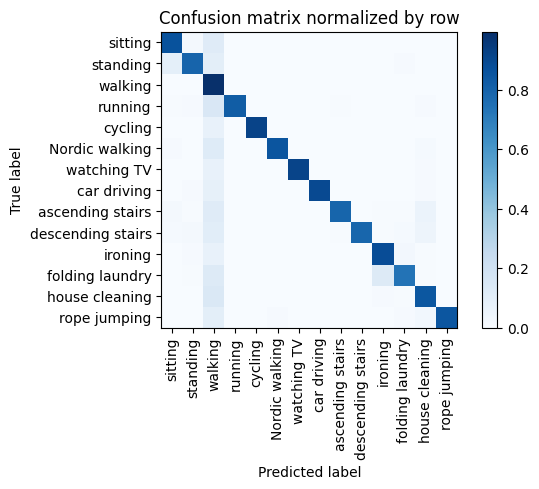

Training Epoch:  80%|████████  | 8/10 [01:45<00:26, 13.43s/it]

Overall accuracy: 0.862



eval: 100%|██████████| 122/122 [00:01<00:00, 66.14batch/s, loss=0.051]


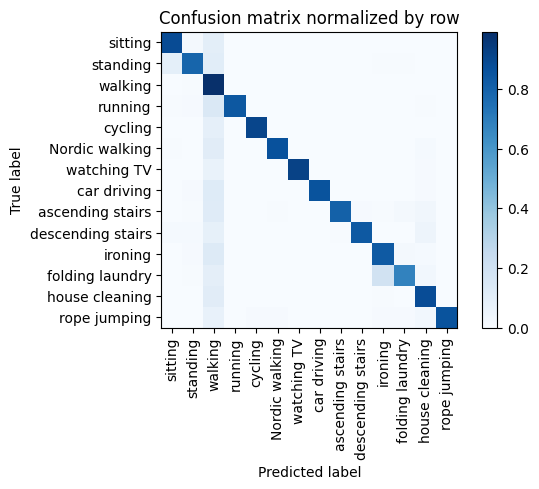

Training Epoch:  90%|█████████ | 9/10 [01:58<00:13, 13.24s/it]

Overall accuracy: 0.861



eval: 100%|██████████| 122/122 [00:02<00:00, 59.38batch/s, loss=0.0419]


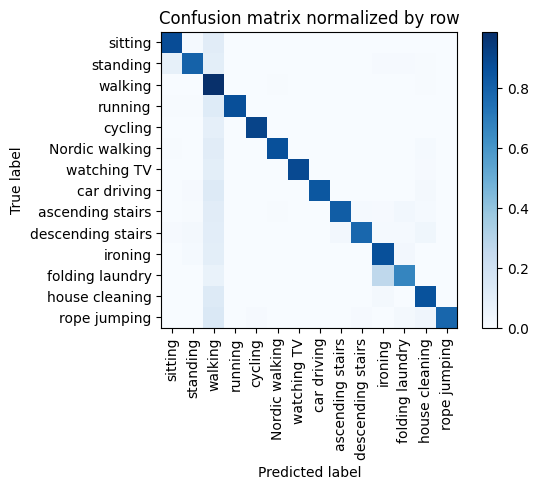

Overall accuracy: 0.857



eval: 100%|██████████| 179/179 [00:01<00:00, 97.91batch/s, loss=0.411] 


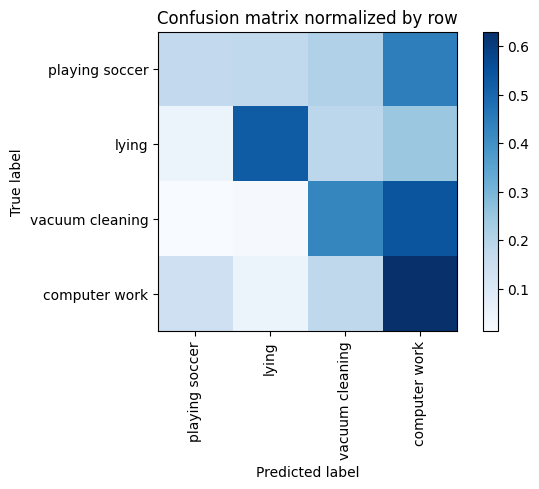

Overall accuracy: 0.522

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.549      0.630      0.586      0.432       2460|	 vacuum cleaning: 0.181,	playing soccer: 0.139,	
          lying       0.784      0.524      0.628      0.264       1505|	 computer work: 0.247,	vacuum cleaning: 0.184,	
vacuum cleaning       0.416      0.425      0.421      0.236       1347|	 computer work: 0.543,	lying: 0.019,	
 playing soccer       0.135      0.173      0.152      0.068        388|	 computer work: 0.443,	vacuum cleaning: 0.209,	lying: 0.175,	

----------------------------------------------------------------------------------------------------
    avg / total       0.552      0.522      0.529        1.0       5700|	      

{'total_accuracy': 0.5224561403508772, 'precision': 0.47119480944725767, 'recall': 0.43799936395614736, 'f1': 0.446864712343229}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'N

eval: 100%|██████████| 139/139 [00:02<00:00, 65.96batch/s, loss=0.119]


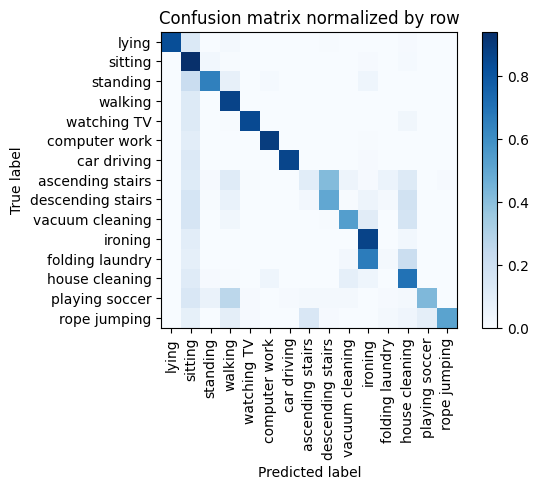

Training Epoch:  10%|█         | 1/10 [00:15<02:17, 15.30s/it]

Overall accuracy: 0.708



eval: 100%|██████████| 139/139 [00:02<00:00, 67.05batch/s, loss=0.0496]


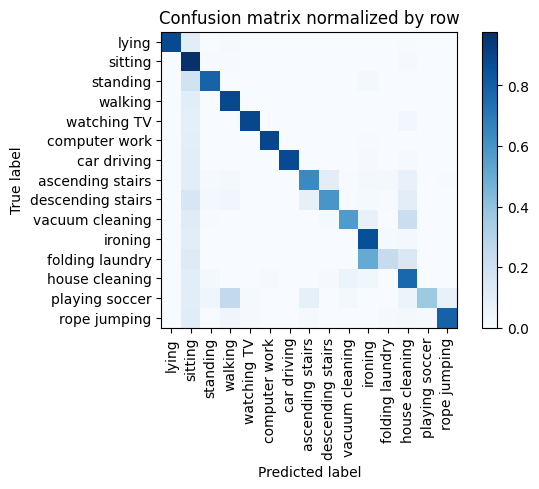

Training Epoch:  20%|██        | 2/10 [00:30<02:02, 15.26s/it]

Overall accuracy: 0.782



eval: 100%|██████████| 139/139 [00:02<00:00, 68.06batch/s, loss=0.101]


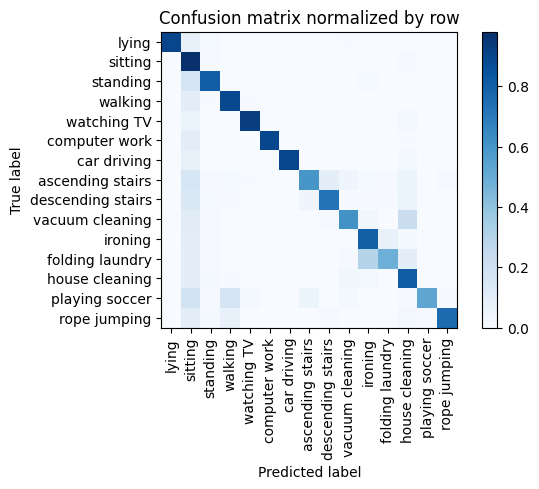

Training Epoch:  30%|███       | 3/10 [00:45<01:45, 15.10s/it]

Overall accuracy: 0.803



eval: 100%|██████████| 139/139 [00:02<00:00, 67.95batch/s, loss=0.0354]


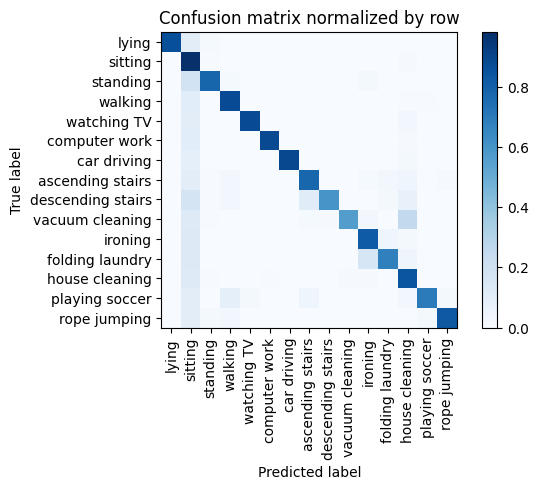

Training Epoch:  40%|████      | 4/10 [01:00<01:29, 14.95s/it]

Overall accuracy: 0.816



eval: 100%|██████████| 139/139 [00:02<00:00, 67.77batch/s, loss=0.0459]


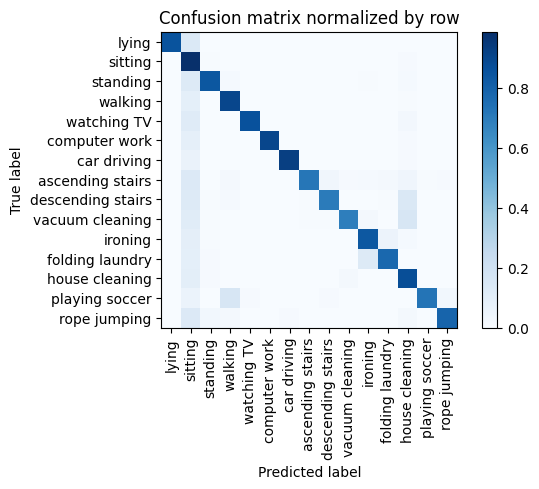

Training Epoch:  50%|█████     | 5/10 [01:14<01:14, 14.87s/it]

Overall accuracy: 0.842



eval: 100%|██████████| 139/139 [00:02<00:00, 57.04batch/s, loss=0.0301]


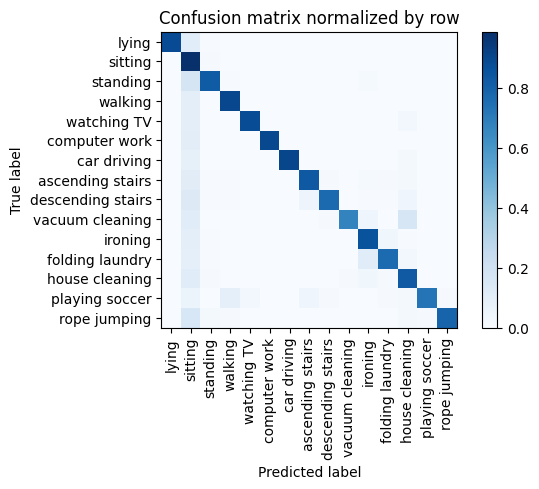

Training Epoch:  60%|██████    | 6/10 [01:30<00:59, 14.99s/it]

Overall accuracy: 0.847



eval: 100%|██████████| 139/139 [00:01<00:00, 69.93batch/s, loss=0.0741]


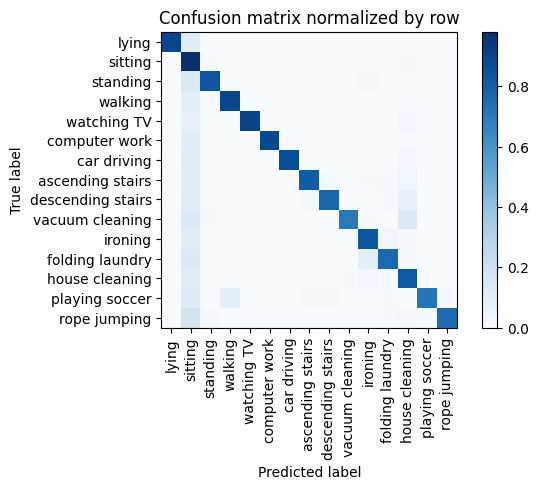

Training Epoch:  70%|███████   | 7/10 [01:44<00:44, 14.76s/it]

Overall accuracy: 0.847



eval: 100%|██████████| 139/139 [00:01<00:00, 72.01batch/s, loss=0.117]


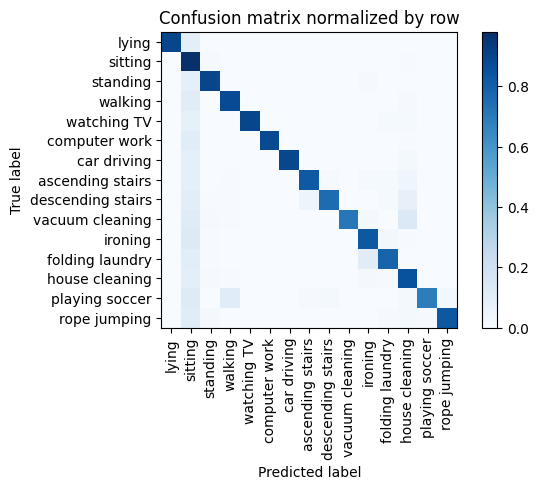

Training Epoch:  80%|████████  | 8/10 [01:57<00:28, 14.20s/it]

Overall accuracy: 0.852



eval: 100%|██████████| 139/139 [00:01<00:00, 73.61batch/s, loss=0.027]


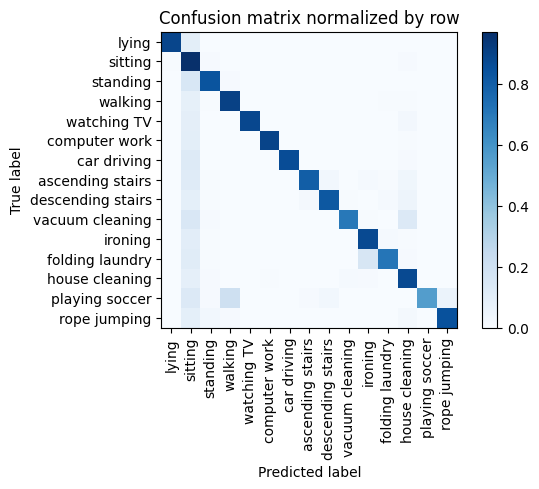

Training Epoch:  90%|█████████ | 9/10 [02:10<00:13, 13.82s/it]

Overall accuracy: 0.853



eval: 100%|██████████| 139/139 [00:02<00:00, 66.19batch/s, loss=0.0841]


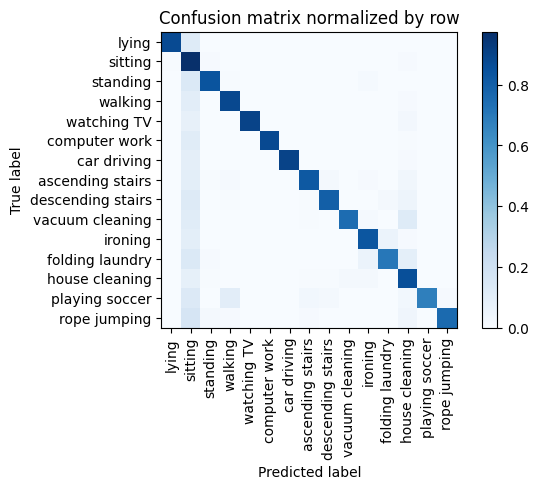

Overall accuracy: 0.847



eval: 100%|██████████| 110/110 [00:01<00:00, 107.48batch/s, loss=0.562]


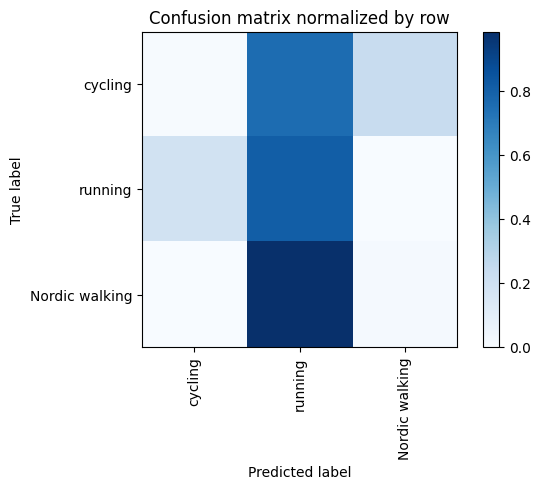

Overall accuracy: 0.178

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.067      0.015      0.024      0.425       1495|	 running: 0.985,	cycling: 0.000,	
       cycling       0.048      0.005      0.010      0.365       1284|	 running: 0.757,	Nordic walking: 0.238,	
       running       0.197      0.810      0.316      0.210        738|	 cycling: 0.190,	Nordic walking: 0.000,	

----------------------------------------------------------------------------------------------------
   avg / total       0.087      0.178      0.080        1.0       3517|	      

{'total_accuracy': 0.17827694057435314, 'precision': 0.10380464351527431, 'recall': 0.27682184514673785, 'f1': 0.1167503630163114}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']


eval: 100%|██████████| 142/142 [00:01<00:00, 73.07batch/s, loss=0.0922]


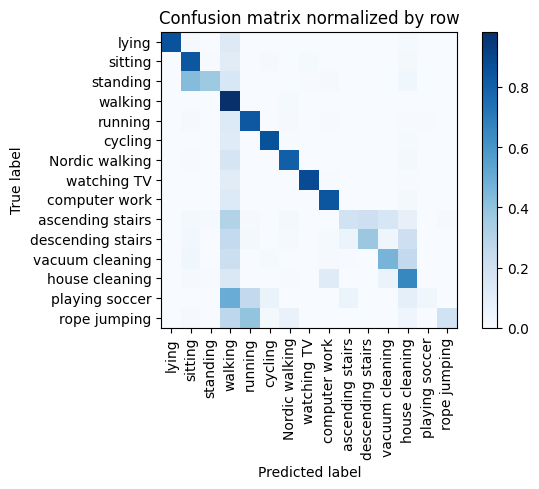

Training Epoch:  10%|█         | 1/10 [00:13<02:05, 13.98s/it]

Overall accuracy: 0.694



eval: 100%|██████████| 142/142 [00:02<00:00, 69.15batch/s, loss=0.104]


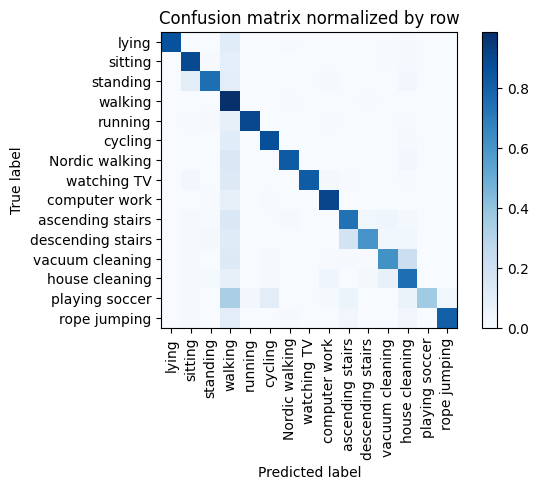

Training Epoch:  20%|██        | 2/10 [00:27<01:48, 13.57s/it]

Overall accuracy: 0.817



eval: 100%|██████████| 142/142 [00:01<00:00, 73.03batch/s, loss=0.0656]


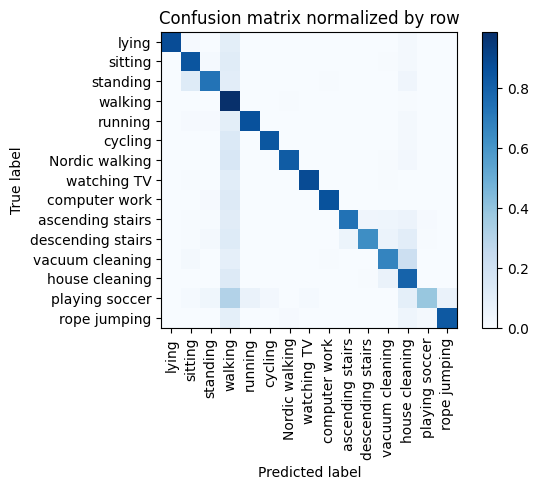

Training Epoch:  30%|███       | 3/10 [00:40<01:34, 13.57s/it]

Overall accuracy: 0.814



eval: 100%|██████████| 142/142 [00:02<00:00, 67.60batch/s, loss=0.0815]


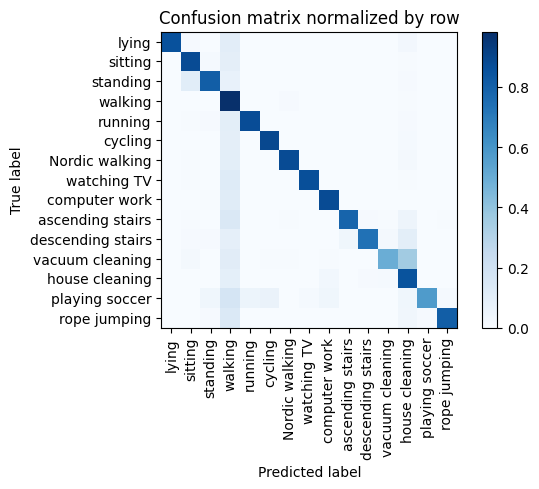

Training Epoch:  40%|████      | 4/10 [00:54<01:22, 13.76s/it]

Overall accuracy: 0.835



eval: 100%|██████████| 142/142 [00:02<00:00, 70.24batch/s, loss=0.0582]


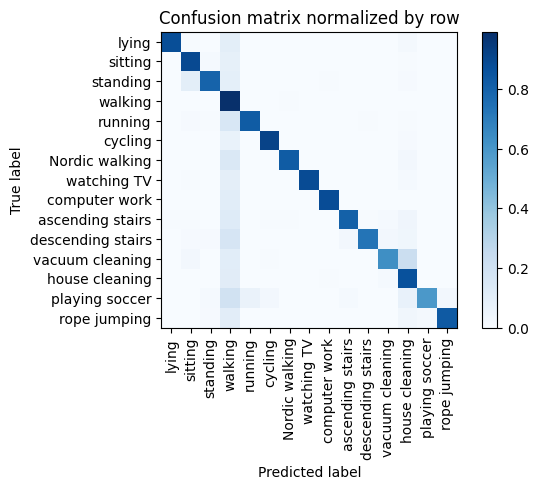

Training Epoch:  50%|█████     | 5/10 [01:09<01:10, 14.04s/it]

Overall accuracy: 0.845



eval: 100%|██████████| 142/142 [00:02<00:00, 61.17batch/s, loss=0.075]


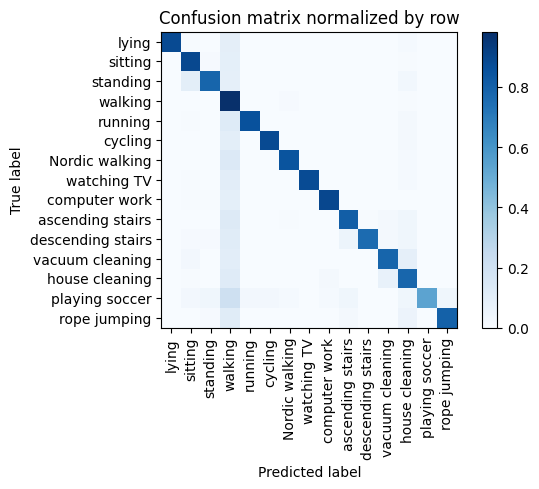

Training Epoch:  60%|██████    | 6/10 [01:24<00:57, 14.39s/it]

Overall accuracy: 0.852



eval: 100%|██████████| 142/142 [00:02<00:00, 67.70batch/s, loss=0.0567]


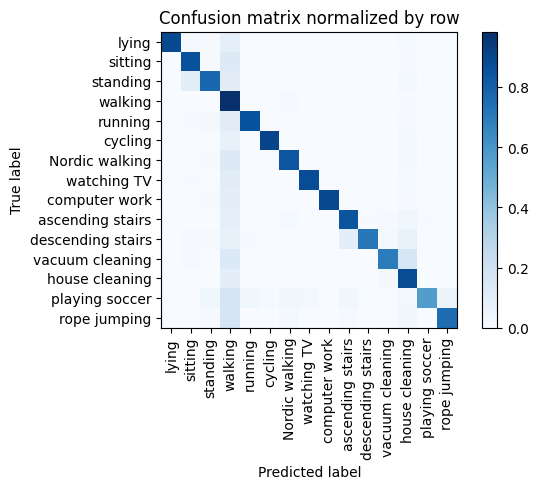

Training Epoch:  70%|███████   | 7/10 [01:38<00:43, 14.36s/it]

Overall accuracy: 0.848



eval: 100%|██████████| 142/142 [00:02<00:00, 64.61batch/s, loss=0.0824]


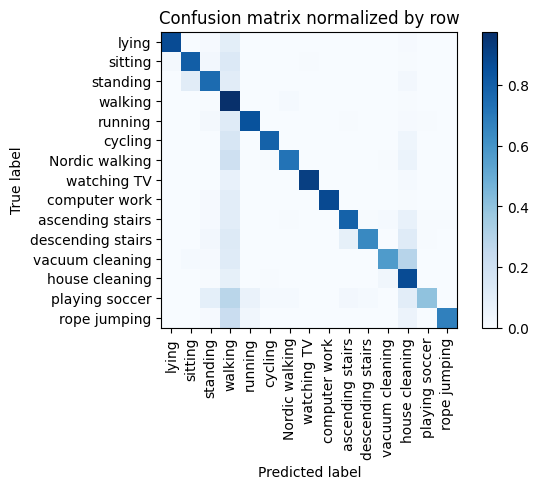

Training Epoch:  80%|████████  | 8/10 [01:53<00:29, 14.61s/it]

Overall accuracy: 0.802



eval: 100%|██████████| 142/142 [00:02<00:00, 68.48batch/s, loss=0.0459]


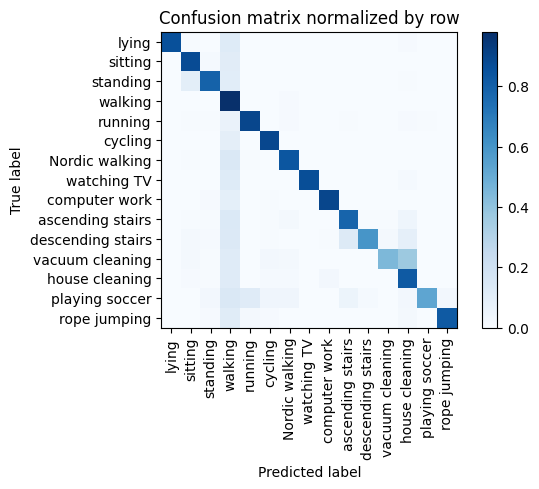

Training Epoch:  90%|█████████ | 9/10 [02:08<00:14, 14.72s/it]

Overall accuracy: 0.820



eval: 100%|██████████| 142/142 [00:02<00:00, 63.76batch/s, loss=0.0602]


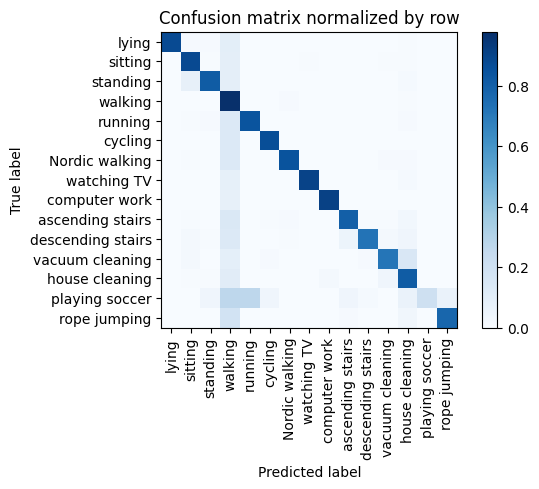

Overall accuracy: 0.842



eval: 100%|██████████| 97/97 [00:01<00:00, 95.76batch/s, loss=0.4]   


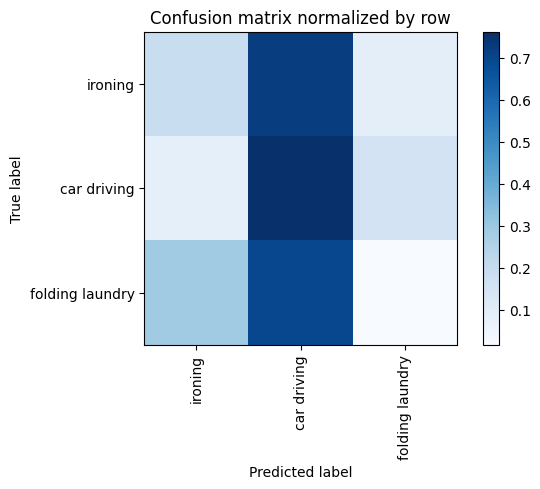

Overall accuracy: 0.224

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.568      0.190      0.285      0.601       1855|	 car driving: 0.721,	folding laundry: 0.088,	
folding laundry       0.054      0.016      0.025      0.261        804|	 car driving: 0.695,	ironing: 0.289,	
    car driving       0.146      0.763      0.245      0.138        426|	 folding laundry: 0.153,	ironing: 0.085,	

----------------------------------------------------------------------------------------------------
    avg / total       0.376      0.224      0.212        1.0       3085|	      

{'total_accuracy': 0.2239870340356564, 'precision': 0.2561405459825737, 'recall': 0.32312548276926495, 'f1': 0.18515406425306238}
============== Overall Unseen Classes Performance ==============


total_accuracy    0.360647
precision         0.308336
recall            0.347784
f1                0.274619
dtype: float64

In [11]:
fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')
    # separate seen/unseen and train/eval 
    data_dict = dataReader.generate(unseen_classes=cs, resampling=True, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=4.21, resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    # print("seen classes > ", seen_classes)
    # print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape
    # build train_dt 
    # print(seen_classes)
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build seen eval_dt 
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=unseen_classes)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    
    # build model
    model = Model6(in_ft=in_ft, d_model=config['d_model'], num_heads=config['num_heads'], ft_size=feat_size, max_len=seq_len)
    # model = Model1(feat_dim=in_ft, max_len=seq_len, d_model=config['d_model'], n_heads=config['num_heads'], num_layers=2, dim_feedforward=128, ft_size=feat_size)
    model.to(device)
    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'])
    loss_module = {'feature': MSELoss(), 'attribute': AttributeLoss()}
    best_acc = 0.0
    # train the model 
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics = train_step(model, train_dl, optimizer, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes], target_feat_met=train_dt.target_feat, phase='train', with_attr=False)
        eval_metrics = eval_step(model, eval_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes],  target_feat_met=eval_dt.target_feat, phase='eval', with_attrs=False, print_report=False)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['total_accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    if best_acc == 0.0:
        best_model = deepcopy(model.state_dict())
    
    # replace by best model 
    model.load_state_dict(best_model)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in unseen_classes],  target_feat_met=test_dt.target_feat, phase='eval', with_attrs=False)
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)
print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
    